In [1]:
Pkg.add("StaticArrays");
Pkg.add("PyPlot");
Pkg.build("PyCall")

INFO: Package StaticArrays is already installed
INFO: METADATA is out-of-date — you may not have the latest version of StaticArrays
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Package PyPlot is already installed
INFO: METADATA is out-of-date — you may not have the latest version of PyPlot
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Building Conda
INFO: Building PyCall
INFO: PyCall is using C:\Users\CedricAlexander.HP-1\.julia\v0.6\Conda\deps\usr\python.exe (Python 2.7.13) at C:\Users\CedricAlexander.HP-1\.julia\v0.6\Conda\deps\usr\python.exe, libpython = C:\Users\CedricAlexander.HP-1\.julia\v0.6\Conda\deps\usr\python27
INFO: C:\Users\CedricAlexander.HP-1\.julia\v0.6\PyCall\deps\deps.jl has not changed
INFO: C:\Users\CedricAlexander.HP-1\.julia\v0.6\PyCall\deps\PYTHON has not changed


In [2]:
using PyPlot
using StaticArrays

# Motivación

### Sistemas dinámicos

Cualquier fenómeno que evoluciona en el tiempo puede ser considerado como un sistema dinámico. Éste sistema se llamará _determinístico_ si se pueden conocer con precisión las reglas de evolución para el futuro, es decir, que dadas las condiciones iniciales del sistema, se puede conocer el estado en cualquier momento del futuro.

Así, un _billar plano_ es el sistema dinámico que, dentro de un conjunto compacto y conexo $Q$, describe el movimiento de una partícula puntual. Dentro de $Q$ el movimiento es uniforme (es decir, tiene velocidad constante) y la reflexión en la frontera es elástica.

Se pueden estudiar muchos billares con formas distintas y cada uno es una clara muestra del caos determinista.
El proyecto siguiente se concentra en el billar de Estadio, por lo que se omitirán de esta introducción.


### Billar de estadio

Partiendo del billar elíptico, se sabe que el espacio de fase no tiene singularidades visibles, pues no tiene vértices y no existen trayectorias tangentes dentro del billar, ya que las trayectorias se restringen a los puntos $ \theta=\pm \left(\frac{pi}{2}\right)$ del espacio de fase.

Ahora, modificando el borde, cortando la elipse por el eje menor, separando las mitades y uniendo las puntas libres con segmentos de recta de una distancia conocida, se obtiene el billar con forma de estadio, _estadio elíptico_. 

Si ahora las curvas de los extremos son semicírculos de radio $ r$, el estadio se llama de _Bunimovich_.

Una vez más, no existen las trayectorias tangentes dentro del espacio de fase de dicho billar, pero ahora si hay cuatro vértices en los puntos donde se unen las rectas con los semicírculos. En estos puntos, la frontera tiene derivada continua, pero su curvatura (que va directamente relacionada con la segunda derivada) es discontinua. 

Resulta que en esos vértices existen singularidades para el espacio de fase, y el estudio de su distribución es fundamental para entender el comportamiento estadístico de los billares dinámicos.

El caso del estadio elíptico presenta trayectorias mucho más complejas que el billar con forma de elipse. El comportamiento general de las partículas depende principalmente de los valores que tome el radio de la semicircunferencia y las longitudes de los segmentos de recta. 

En este proyecto se busca conocer un poco mejor, el comportamiento de las partículas para valores del radio y longitudes dadas.

Como propuesta extra se plantea el _Billar de Sinaí_, el cual plantea el mismo billar que de _Bunimovich_, pero considerando ahora una circunferencia de radio $s<r$ en el origen como obstáculo extra.

### Geometría del Problema
El problema a resolver es el de una reflexión clásica en superficies con curvatura constante, ya sean paredes rectas, o bien, medias circunferencias.

![Image Test](billar.png)

Para definir la reflexión en un punto consideremos lo siguiente:

Sea $\hat{n}={n \over \|n\|}$.

Donde $\hat{n}$ es el vector unitario que va en la misma dirección que $n$.

Ahora, la proyección de $d$ en la dirección $n$ está dada por $\mathrm{proj}_{n}d = (d \cdot \hat{n})\hat{n}$, y la proyección de $d$ en la dirección ortogonal está dada entonces por $d - (d \cdot \hat{n})\hat{n}$. Por lo que tenemos que: 

$$d = (d \cdot \hat{n})\hat{n} + [d - (d \cdot \hat{n})\hat{n}]$$

Notemos que $r$ tiene $-1$ veces la proyección en $n$ que $d$ tiene a su vez en $n$, mientras que la proyección ortogonal de $r$ en $n$ es igual a la proyección ortogonal de $d$ en $n$, por lo que:

$$r = -(d \cdot \hat{n})\hat{n} + [d - (d \cdot \hat{n})\hat{n}]$$

Podemos verlo también como que $-r$ tiene la misma proyección en $n$ que $d$ tienen en $n$, con su proyección ortogonal dada por $-1$ veces aquella de $d$. 

$$-r = (d \cdot \hat{n})\hat{n} - [d - (d \cdot \hat{n})\hat{n}]$$

Donde la última ecuación es exactamente:

$$r = -(d \cdot \hat{n})\hat{n} + [d - (d \cdot \hat{n})\hat{n}]$$

De donde podemos obtener $r$ de $d$ via

$$r = d - 2(d \cdot \hat{n})\hat{n}$$

Y en términos de $n$ mism, obtenemos:

$$r = d - {2 d \cdot n\over \|n\|^2}n$$

Resultado que ocuparemos después para definir el vector resultante.

In [137]:
function billar(x0,y0,vx,vy,prim, it)
 err=0.02                      # Se define el error para dar una mejor aproximación de las colisiones con las paredes
 posBarrx=5                    # Se define la posición de las barreras laterales
 t=linspace(0,100,10000);      # Se define lista de 10000 "tiempos"
    
for j in 1:it 
       posx = zeros(10000);     # Se define una lista de 1000 entradas para guardar la posición en x & y.
       posy = zeros(10000);
    choquex = zeros(it);        # Lista para guardar donde choca en x & y
    choquey = zeros(it);
    
    # Primero guardemos la trayectoria de las particula en las siguientes listas:    

    for i in 1:10000
        posx[i] = x0+vx*t[i]
        posy[i] = y0+vy*t[i]
    end
            # Se revisa la posición de choque como sigue:
            for i in 1:10000     # Se hacen correr todos los puntos (x,y) de la trayectoria y se observa cuando 
                                 # cumplen la ecuación de la circunferencia " y = sqrt(1-x^2) "
            
      # Una vez guardado los datos, se definen una serie de "ifs" que revisan cuando la posición de la partícula
            #cumple con las ecuaciones de la circunferencia (x^2+y^2=r^2). Se hacen 4 "ifs" para los dos medios círculos
                #y dos más para las barreras laterales.
            

                    # Media circunferencia superior derecha
                    if abs(posy[i]-5-sqrt(25-(posx[i])*(posx[i])))<err  && 0<posx[i]<5.1                      
                          x0 = posx[i]; # Guardamos la posición del choque en la posición donde se cunple el "if"
                          y0 = posy[i];
                           m = x0/sqrt(abs(25.001-x0^2));  # Encontramos la pendiente del plano tangente definido 
                                                           # por su derivada
                            if x0 > 0        # Definimos este "if" para que no haya problemas
                                m=-abs(m)
                                end 
                        phi = atand(m);      # El ángulo del plano con la horizontal
                         cx = cosd(phi);     # Se calculan la componentes de la normal
                         cy = sind(phi);     # "cx" es la normal en "x" y "cy" la normal en "y"
                          n = SVector(abs(cy), abs(cx));     # Definimos la normal con los vectores normales
                          V = SVector(vx, vy);     # Se define el vector director con las velocidades iniciales
                            k2=dot(2V,n)           # A continuación se encuentra el vector resultante
                            k3=k2*n                # Esto pudo haber sido una sola linea pero
                            r=V-k3                 # Había problemas y por eso no salía
                         vx = r[1];       # Se renombran "vx" y "vy" como la primera y segunda entrada del                   
                         vy = r[2];       # vector resultante
                         x0 = posx[i-1];  # Por último, guardamos un paso antes para que no haya problemas
                         y0 = posy[i-1];  # en la siguiente iteración.
                              break
                
                      # Media circunferencia superior izquierda  
                elseif abs(posy[i]-5-sqrt(25-(posx[i])*(posx[i])))<err  && 0>posx[i]>-5.1                    
                         x0 = posx[i];
                          y0 = posy[i];
                         m = x0/sqrt(abs(25.001-x0^2));
                            if x0 > 0
                                m=-abs(m)
                                end 
                        phi = atand(m); 
                         cx = cosd(phi);  
                         cy = sind(phi);9
                          n = SVector(abs(cy), -abs(cx));
                          V = SVector(vx, vy);
                            k2=dot(2V,n)
                            k3=k2*n
                            r=V-k3
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break
                
                         # Media circunferencia inferior izquierda  
                        elseif abs(posy[i]+5+sqrt(25-(posx[i])*(posx[i])))<err  &&   0>posx[i]>-5.1                 
                          x0 = posx[i];
                          y0 = posy[i];
                         m = x0/sqrt(abs(25.001-x0^2));
                            if x0 > 0
                                m=abs(m)
                                end 
                        phi = atand(m);
                         cx = cosd(phi);
                         cy = sind(phi);
                          n = SVector(-abs(cy), -abs(cx));
                          V = SVector(vx, vy);
                            k2=dot(2V,n)
                            k3=k2*n
                            r=V-k3
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break
                
                         # Media circunferencia inferior derecha
                        elseif abs(posy[i]+5+sqrt(25-(posx[i])*(posx[i])))<err  && 0<posx[i]<5.1              
                        x0 = posx[i];
                          y0 = posy[i];
                         m = x0/sqrt(abs(25.001-x0^2));
                            if x0 > 0
                                m=abs(m)
                                end 
                        phi = atand(m); 
                         cx = cosd(phi);
                         cy = sind(phi);
                          n = SVector(-abs(cy), abs(cx));
                          V = SVector(vx, vy); 
                            k2=dot(2V,n)
                            k3=k2*n
                            r=V-k3
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break

                #Ahora para las paredes verticales:

                          # Pared izquierda
                            elseif abs(posx[i]+posBarrx)<err  && posx[i]<0 &&abs(posy[i])<6
                                    x0=posx[i-1]   # Para no tener problemas en la siguiente iteración
                                    y0 = posy[i];
                                    vx = -vx;      # Ya que es lo única componente que cambia 
                                     break
                         
                            # Pared derecha
                            elseif abs(posx[i]-posBarrx)<err && posx[i]>0 && abs(posy[i])<6
                                    x0=posx[i-1]
                                    y0 = posy[i];
                                    vx = -vx;
                                     break   
                    end 
                   if j>prim #imponemos esta condicion para solo graficar el j-esimo choque
             push!(choquex,posx[i]) # Para cada "i" guardamos "posx[i]" y "posy[i]" en las listas
             push!(choquey,posy[i]) # "choquex" y "choquey"
            end
             end


        
    x1 = linspace(-5.0, 5, 100)     # Se define un linspace para poder graficar los medios círculos
 
 yar = 5+sqrt.(abs.(25-x1.*x1))     # Se definen las ecuaciones de los medios circulos para poder graficar
 yab = -5-sqrt.(abs.(25-x1.*x1))
 
 x12 = linspace(-0.5, 0.5, 100)     # Se define un linspace para poder graficar el círculo central en un futuro
 yar2 = sqrt.(abs.(0.25-x12.*x12))  # Se definen las ecuaciones del círculo central para graficar 
 yab2 = -sqrt.(abs.(0.25-x12.*x12))     
        
        
        
 plot(x1, yab,color="black")        # Estas son las graficas de los circulos:
 plot(x1, yar,color="black")
        
        
 plot([-5,-5],[-5,5],linestyle="-",linewidth=1,color="black")  # Aquí graficamos las lineas horizontales
 plot([5,5],[-5,5],linestyle="-",linewidth=1,color="black")
        
        
 xlim(-11, 11)
 ylim(-10.5, 10.5)

# Esta es la gráfica de las trayectorias
plot(choquex,choquey,color="darkred",linewidth=0.002,marker=">", markersize=.5,antialiased= true)    
title("Billar de Bunimovich",color="darkblue")
xlabel("Posición en x ",color="darkblue")
ylabel("Posición en y ",color="darkblue")
legend()
    end
end

billar (generic function with 1 method)

A continuación probamos la función para el Billar de Bunimovich.

Las entradas de la función son, respectivamente:

* Posición inicial en "x"
* Posición inicial en "y"
* Velocidad inicial en "x"
* Velocidad inicial en "y"
* Repetición en la cual se iniciará a graficar (esto será útil para observar el caos del sistema en ejemplos posteriores)
* Número de choques

# Billar de Bunimovich

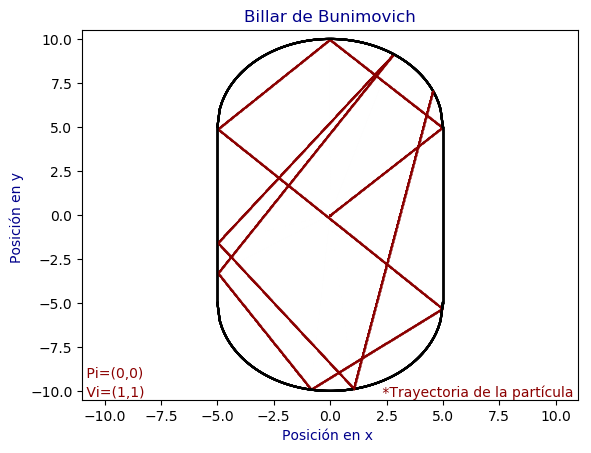

In [138]:
billar(0,0,1,1,0,10)
annotate(" *Trayectoria de la partícula ",
	xy=[1;0],
	xycoords="axes fraction",
	color="darkred",
	ha="right",
	va="bottom")
annotate(" Pi=(0,0)",
	xy=[0;0.05],
	xycoords="axes fraction",
	color="darkred",
	ha="left",
	va="bottom")
annotate(" Vi=(1,1)",
	xy=[0;0],
	xycoords="axes fraction",
	color="darkred",
	ha="left",
	va="bottom");

Ahora para una posición inicial diferente al origen y diferentes velocidades:

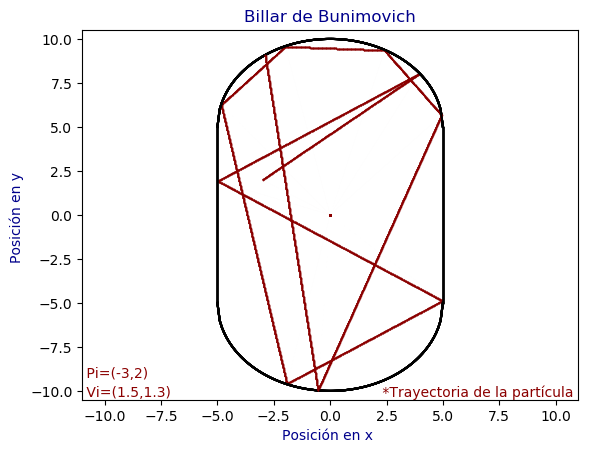

In [105]:
billar(-3,2,1.5,1.3,0,10)
annotate(" *Trayectoria de la partícula ",
	xy=[1;0],
	xycoords="axes fraction",
	color="darkred",
	ha="right",
	va="bottom")
annotate(" Pi=(-3,2)",
	xy=[0;0.05],
	xycoords="axes fraction",
	color="darkred",
	ha="left",
	va="bottom")
annotate(" Vi=(1.5,1.3)",
	xy=[0;0],
	xycoords="axes fraction",
	color="darkred",
	ha="left",
	va="bottom");

Ahora, graficando solo el 9no y 10mo golpe:

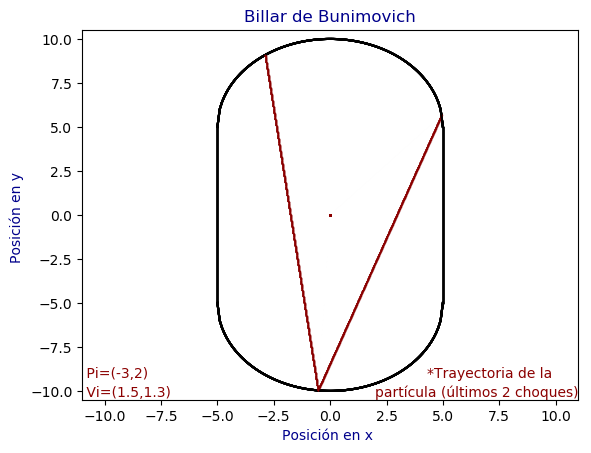

In [118]:
billar(-3,2,1.5,1.3,8,10)
annotate("*Trayectoria de la      ",
	xy=[1;0.05],
	xycoords="axes fraction",
	color="darkred",
	ha="right",
	va="bottom")
annotate("partícula (últimos 2 choques)",
	xy=[1;0],
	xycoords="axes fraction",
	color="darkred",
	ha="right",
	va="bottom")
annotate(" Pi=(-3,2)",
	xy=[0;0.05],
	xycoords="axes fraction",
	color="darkred",
	ha="left",
	va="bottom")
annotate(" Vi=(1.5,1.3)",
	xy=[0;0],
	xycoords="axes fraction",
	color="darkred",
	ha="left",
	va="bottom");

Ahora que ya hemos definido la función, vamos a ver su comportamiento caótico, la forma más fácil es definir la misma funcion y solo cambiar el color de la trayectoria y cambiar sus ecuaciones inciales.Vamos a definir dos funciones identicas más pedro ahora con colores azul y verde:

In [202]:
function billarblue(x0,y0,vx,vy,prim, it)
 err=0.02                      # Se define el error para dar una mejor aproximación de las colisiones con las paredes
 posBarrx=5                    # Se define la posición de las barreras laterales
 t=linspace(0,100,10000);      # Se define lista de 10000 "tiempos"
    
for j in 1:it 
       posx = zeros(10000);     # Se define una lista de 1000 entradas para guardar la posición en x & y.
       posy = zeros(10000);
    choquex = zeros(it);        # Lista para guardar donde choca en x & y
    choquey = zeros(it);
    
    # Primero guardemos la trayectoria de las particula en las siguientes listas:    

    for i in 1:10000
        posx[i] = x0+vx*t[i]
        posy[i] = y0+vy*t[i]
    end
            # Se revisa la posición de choque como sigue:
            for i in 1:10000     # Se hacen correr todos los puntos (x,y) de la trayectoria y se observa cuando 
                                 # cumplen la ecuación de la circunferencia " y = sqrt(1-x^2) "
            
      # Una vez guardado los datos, se definen una serie de "ifs" que revisan cuando la posición de la partícula
            #cumple con las ecuaciones de la circunferencia (x^2+y^2=r^2). Se hacen 4 "ifs" para los dos medios círculos
                #y dos más para las barreras laterales.
            

                    # Media circunferencia superior derecha
                    if abs(posy[i]-5-sqrt(25-(posx[i])*(posx[i])))<err  && 0<posx[i]<5.1                      
                          x0 = posx[i]; # Guardamos la posición del choque en la posición donde se cunple el "if"
                          y0 = posy[i];
                           m = x0/sqrt(abs(25.001-x0^2));  # Encontramos la pendiente del plano tangente definido 
                                                           # por su derivada
                            if x0 > 0        # Definimos este "if" para que no haya problemas
                                m=-abs(m)
                                end 
                        phi = atand(m);      # El ángulo del plano con la horizontal
                         cx = cosd(phi);     # Se calculan la componentes de la normal
                         cy = sind(phi);     # "cx" es la normal en "x" y "cy" la normal en "y"
                          n = SVector(abs(cy), abs(cx));     # Definimos la normal con los vectores normales
                          V = SVector(vx, vy);     # Se define el vector director con las velocidades iniciales
                            k2=dot(2V,n)           # A continuación se encuentra el vector resultante
                            k3=k2*n                # Esto pudo haber sido una sola linea pero
                            r=V-k3                 # Había problemas y por eso no salía
                         vx = r[1];       # Se renombran "vx" y "vy" como la primera y segunda entrada del                   
                         vy = r[2];       # vector resultante
                         x0 = posx[i-1];  # Por último, guardamos un paso antes para que no haya problemas
                         y0 = posy[i-1];  # en la siguiente iteración.
                              break
                
                      # Media circunferencia superior izquierda  
                elseif abs(posy[i]-5-sqrt(25-(posx[i])*(posx[i])))<err  && 0>posx[i]>-5.1                    
                         x0 = posx[i];
                          y0 = posy[i];
                         m = x0/sqrt(abs(25.001-x0^2));
                            if x0 > 0
                                m=-abs(m)
                                end 
                        phi = atand(m); 
                         cx = cosd(phi);  
                         cy = sind(phi);9
                          n = SVector(abs(cy), -abs(cx));
                          V = SVector(vx, vy);
                            k2=dot(2V,n)
                            k3=k2*n
                            r=V-k3
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break
                
                         # Media circunferencia inferior izquierda  
                        elseif abs(posy[i]+5+sqrt(25-(posx[i])*(posx[i])))<err  &&   0>posx[i]>-5.1                 
                          x0 = posx[i];
                          y0 = posy[i];
                         m = x0/sqrt(abs(25.001-x0^2));
                            if x0 > 0
                                m=abs(m)
                                end 
                        phi = atand(m);
                         cx = cosd(phi);
                         cy = sind(phi);
                          n = SVector(-abs(cy), -abs(cx));
                          V = SVector(vx, vy);
                            k2=dot(2V,n)
                            k3=k2*n
                            r=V-k3
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break
                
                         # Media circunferencia inferior derecha
                        elseif abs(posy[i]+5+sqrt(25-(posx[i])*(posx[i])))<err  && 0<posx[i]<5.1              
                        x0 = posx[i];
                          y0 = posy[i];
                         m = x0/sqrt(abs(25.001-x0^2));
                            if x0 > 0
                                m=abs(m)
                                end 
                        phi = atand(m); 
                         cx = cosd(phi);
                         cy = sind(phi);
                          n = SVector(-abs(cy), abs(cx));
                          V = SVector(vx, vy); 
                            k2=dot(2V,n)
                            k3=k2*n
                            r=V-k3
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break

                #Ahora para las paredes verticales:

                          # Pared izquierda
                            elseif abs(posx[i]+posBarrx)<err  && posx[i]<0 &&abs(posy[i])<6
                                    x0=posx[i-1]   # Para no tener problemas en la siguiente iteración
                                    y0 = posy[i];
                                    vx = -vx;      # Ya que es lo única componente que cambia 
                                     break
                         
                            # Pared derecha
                            elseif abs(posx[i]-posBarrx)<err && posx[i]>0 && abs(posy[i])<6
                                    x0=posx[i-1]
                                    y0 = posy[i];
                                    vx = -vx;
                                     break   
                    end 
       
               if j>prim
             push!(choquex,posx[i]) # Para cada "i" guardamos "posx[i]" y "posy[i]" en las listas
             push!(choquey,posy[i]) # "choquex" y "choquey"
            end
             end


        
    x1 = linspace(-5.0, 5, 100)     # Se define un linspace para poder graficar los medios círculos
 
 yar = 5+sqrt.(abs.(25-x1.*x1))     # Se definen las ecuaciones de los medios circulos para poder graficar
 yab = -5-sqrt.(abs.(25-x1.*x1))
 
 x12 = linspace(-0.5, 0.5, 100)     # Se define un linspace para poder graficar el círculo central en un futuro
 yar2 = sqrt.(abs.(0.25-x12.*x12))  # Se definen las ecuaciones del círculo central para graficar 
 yab2 = -sqrt.(abs.(0.25-x12.*x12))     
        
        
        
 plot(x1, yab,color="black")        # Estas son las graficas de los circulos:
 plot(x1, yar,color="black")
        
        
 plot([-5,-5],[-5,5],linestyle="-",linewidth=1,color="black")  # Aquí graficamos las lineas horizontales
 plot([5,5],[-5,5],linestyle="-",linewidth=1,color="black")
        
        
 xlim(-11, 11)
 ylim(-10.5, 10.5)

# Esta es la gráfica de las trayectorias        
plot(choquex,choquey, ".",alpha=1, linewidth=0.002, color="blue", markersize=1,antialiased= "true" )
    end
end



function billargreen(x0,y0,vx,vy,prim,it)
 err=0.02                      # Se define el error para dar una mejor aproximación de las colisiones con las paredes
 posBarrx=5                    # Se define la posición de las barreras laterales
 t=linspace(0,100,10000);      # Se define lista de 10000 "tiempos"
    
for j in 1:it 
       posx = zeros(10000);     # Se define una lista de 1000 entradas para guardar la posición en x & y.
       posy = zeros(10000);
    choquex = zeros(it);        # Lista para guardar donde choca en x & y
    choquey = zeros(it);
    
    # Primero guardemos la trayectoria de las particula en las siguientes listas:    

    for i in 1:10000
        posx[i] = x0+vx*t[i]
        posy[i] = y0+vy*t[i]
    end
            # Se revisa la posición de choque como sigue:
            for i in 1:10000     # Se hacen correr todos los puntos (x,y) de la trayectoria y se observa cuando 
                                 # cumplen la ecuación de la circunferencia " y = sqrt(1-x^2) "
            
      # Una vez guardado los datos, se definen una serie de "ifs" que revisan cuando la posición de la partícula
            #cumple con las ecuaciones de la circunferencia (x^2+y^2=r^2). Se hacen 4 "ifs" para los dos medios círculos
                #y dos más para las barreras laterales.
            

                    # Media circunferencia superior derecha
                    if abs(posy[i]-5-sqrt(25-(posx[i])*(posx[i])))<err  && 0<posx[i]<5.1                      
                          x0 = posx[i]; # Guardamos la posición del choque en la posición donde se cunple el "if"
                          y0 = posy[i];
                           m = x0/sqrt(abs(25.001-x0^2));  # Encontramos la pendiente del plano tangente definido 
                                                           # por su derivada
                            if x0 > 0        # Definimos este "if" para que no haya problemas
                                m=-abs(m)
                                end 
                        phi = atand(m);      # El ángulo del plano con la horizontal
                         cx = cosd(phi);     # Se calculan la componentes de la normal
                         cy = sind(phi);     # "cx" es la normal en "x" y "cy" la normal en "y"
                          n = SVector(abs(cy), abs(cx));     # Definimos la normal con los vectores normales
                          V = SVector(vx, vy);     # Se define el vector director con las velocidades iniciales
                            k2=dot(2V,n)           # A continuación se encuentra el vector resultante
                            k3=k2*n                # Esto pudo haber sido una sola linea pero
                            r=V-k3                 # Había problemas y por eso no salía
                         vx = r[1];       # Se renombran "vx" y "vy" como la primera y segunda entrada del                   
                         vy = r[2];       # vector resultante
                         x0 = posx[i-1];  # Por último, guardamos un paso antes para que no haya problemas
                         y0 = posy[i-1];  # en la siguiente iteración.
                              break
                
                      # Media circunferencia superior izquierda  
                elseif abs(posy[i]-5-sqrt(25-(posx[i])*(posx[i])))<err  && 0>posx[i]>-5.1                    
                         x0 = posx[i];
                          y0 = posy[i];
                         m = x0/sqrt(abs(25.001-x0^2));
                            if x0 > 0
                                m=-abs(m)
                                end 
                        phi = atand(m); 
                         cx = cosd(phi);  
                         cy = sind(phi);9
                          n = SVector(abs(cy), -abs(cx));
                          V = SVector(vx, vy);
                            k2=dot(2V,n)
                            k3=k2*n
                            r=V-k3
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break
                
                         # Media circunferencia inferior izquierda  
                        elseif abs(posy[i]+5+sqrt(25-(posx[i])*(posx[i])))<err  &&   0>posx[i]>-5.1                 
                          x0 = posx[i];
                          y0 = posy[i];
                         m = x0/sqrt(abs(25.001-x0^2));
                            if x0 > 0
                                m=abs(m)
                                end 
                        phi = atand(m);
                         cx = cosd(phi);
                         cy = sind(phi);
                          n = SVector(-abs(cy), -abs(cx));
                          V = SVector(vx, vy);
                            k2=dot(2V,n)
                            k3=k2*n
                            r=V-k3
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break
                
                         # Media circunferencia inferior derecha
                        elseif abs(posy[i]+5+sqrt(25-(posx[i])*(posx[i])))<err  && 0<posx[i]<5.1              
                        x0 = posx[i];
                          y0 = posy[i];
                         m = x0/sqrt(abs(25.001-x0^2));
                            if x0 > 0
                                m=abs(m)
                                end 
                        phi = atand(m); 
                         cx = cosd(phi);
                         cy = sind(phi);
                          n = SVector(-abs(cy), abs(cx));
                          V = SVector(vx, vy); 
                            k2=dot(2V,n)
                            k3=k2*n
                            r=V-k3
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break

                #Ahora para las paredes verticales:

                          # Pared izquierda
                            elseif abs(posx[i]+posBarrx)<err  && posx[i]<0 &&abs(posy[i])<6
                                    x0=posx[i-1]   # Para no tener problemas en la siguiente iteración
                                    y0 = posy[i];
                                    vx = -vx;      # Ya que es lo única componente que cambia 
                                     break
                         
                            # Pared derecha
                            elseif abs(posx[i]-posBarrx)<err && posx[i]>0 && abs(posy[i])<6
                                    x0=posx[i-1]
                                    y0 = posy[i];
                                    vx = -vx;
                                     break   
                    end 
       
               if j>prim
             push!(choquex,posx[i]) # Para cada "i" guardamos "posx[i]" y "posy[i]" en las listas
             push!(choquey,posy[i]) # "choquex" y "choquey"
            end
             end


        
 x1 = linspace(-5.0, 5, 100)     # Se define un linspace para poder graficar los medios círculos
 
 yar = 5+sqrt.(abs.(25-x1.*x1))     # Se definen las ecuaciones de los medios circulos para poder graficar
 yab = -5-sqrt.(abs.(25-x1.*x1))
 
 x12 = linspace(-0.5, 0.5, 100)     # Se define un linspace para poder graficar el círculo central en un futuro
 yar2 = sqrt.(abs.(0.25-x12.*x12))  # Se definen las ecuaciones del círculo central para graficar 
 yab2 = -sqrt.(abs.(0.25-x12.*x12))     
        
        
        
 plot(x1, yab,color="black")        # Estas son las graficas de los circulos:
 plot(x1, yar,color="black")
        
        
 plot([-5,-5],[-5,5],linestyle="-",linewidth=1,color="black")  # Aquí graficamos las lineas horizontales
 plot([5,5],[-5,5],linestyle="-",linewidth=1,color="black")
        
        
 xlim(-11, 11)
 ylim(-10.5, 10.5)
        

# Esta es la gráfica de las trayectorias        
plot(choquex,choquey, ".",alpha=1, linewidth=0.002, color="green", markersize=1,antialiased= "true" )    
title("Billar de Bunimovich",color="#5A5300")
xlabel("Posición en x ",color="#5A5300")
ylabel("Posición en y ",color="#5A5300")
legend()  
    end
end

billargreen (generic function with 1 method)

Veamos las primeras 5 iteraciones o rebotes:

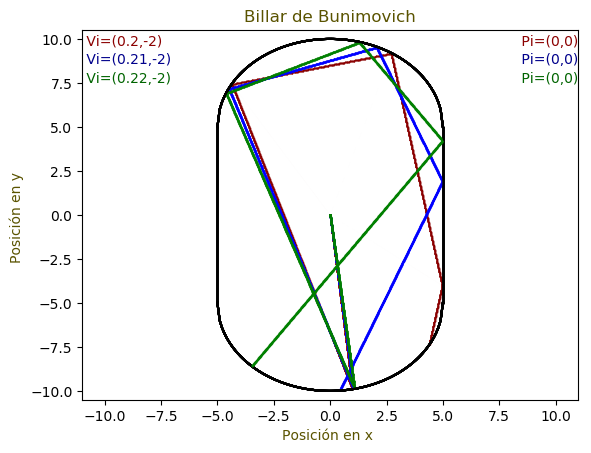

In [203]:
billar(0,0,0.2,-2,0,5)  #rojo: graficamos una particula que sale del origen con velocidad (0.2, -2)
billarblue(0,0,0.21,-2,0,5) #azul: graficamos una particula que sale del origen con velocidad (0.21, -2)
billargreen(0,0,0.22,-2,0,5) #verde: graficamos una particula que sale del origen con velocidades (0.22, -2)

annotate(" Pi=(0,0)",
	xy=[1;0.95],
	xycoords="axes fraction",
	color="darkred",
	ha="right",
	va="bottom")
annotate(" Vi=(0.2,-2)",
	xy=[0;0.95],
	xycoords="axes fraction",
	color="darkred",
	ha="left",
	va="bottom")
annotate(" Pi=(0,0)",
	xy=[1;0.9],
	xycoords="axes fraction",
	color="darkblue",
	ha="right",
	va="bottom")
annotate(" Vi=(0.21,-2)",
	xy=[0;0.9],
	xycoords="axes fraction",
	color="darkblue",
	ha="left",
	va="bottom")
annotate(" Pi=(0,0)",
	xy=[1;0.85],
	xycoords="axes fraction",
	color="darkgreen",
	ha="right",
	va="bottom")
annotate(" Vi=(0.22,-2)",
	xy=[0;0.85],
	xycoords="axes fraction",
	color="darkgreen",
	ha="left",
	va="bottom");

Los primeros 7 rebotes:

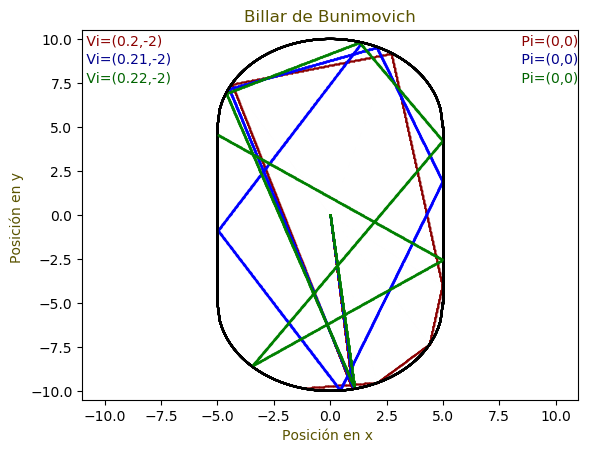

In [185]:
billar(0,0,0.2,-2,0,7)  #rojo: graficamos una particula que sale del origen con velocidad (0.2, -2)
billarblue(0,0,0.21,-2,0,7) #azul: graficamos una particula que sale del origen con velocidad (0.21, -2)
billargreen(0,0,0.22,-2,0,7) #verde: graficamos una particula que sale del origen con velocidades (0.22, -2)

annotate(" Pi=(0,0)",
	xy=[1;0.95],
	xycoords="axes fraction",
	color="darkred",
	ha="right",
	va="bottom")
annotate(" Vi=(0.2,-2)",
	xy=[0;0.95],
	xycoords="axes fraction",
	color="darkred",
	ha="left",
	va="bottom")
annotate(" Pi=(0,0)",
	xy=[1;0.9],
	xycoords="axes fraction",
	color="darkblue",
	ha="right",
	va="bottom")
annotate(" Vi=(0.21,-2)",
	xy=[0;0.9],
	xycoords="axes fraction",
	color="darkblue",
	ha="left",
	va="bottom")
annotate(" Pi=(0,0)",
	xy=[1;0.85],
	xycoords="axes fraction",
	color="darkgreen",
	ha="right",
	va="bottom")
annotate(" Vi=(0.22,-2)",
	xy=[0;0.85],
	xycoords="axes fraction",
	color="darkgreen",
	ha="left",
	va="bottom");

Es complicado diferenciar cada choque.
Veamos la diferencia entre los rebotes del 2 al 5

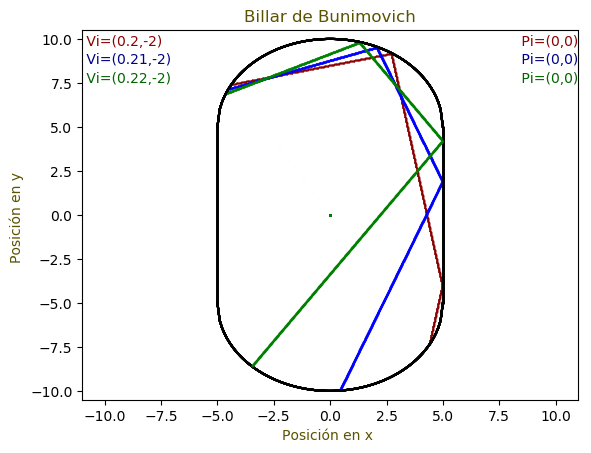

In [266]:
billar(0,0,0.2,-2,2,5)  #rojo: graficamos una particula que sale del origen con velocidad (0.2, -2)
billarblue(0,0,0.21,-2,2,5) #azul: graficamos una particula que sale del origen con velocidad (0.21, -2)
billargreen(0,0,0.22,-2,2,5) #verde: graficamos una particula que sale del origen con velocidades (0.22, -2)
annotate(" Pi=(0,0)",
	xy=[1;0.95],
	xycoords="axes fraction",
	color="darkred",
	ha="right",
	va="bottom")
annotate(" Vi=(0.2,-2)",
	xy=[0;0.95],
	xycoords="axes fraction",
	color="darkred",
	ha="left",
	va="bottom")
annotate(" Pi=(0,0)",
	xy=[1;0.9],
	xycoords="axes fraction",
	color="darkblue",
	ha="right",
	va="bottom")
annotate(" Vi=(0.21,-2)",
	xy=[0;0.9],
	xycoords="axes fraction",
	color="darkblue",
	ha="left",
	va="bottom")
annotate(" Pi=(0,0)",
	xy=[1;0.85],
	xycoords="axes fraction",
	color="darkgreen",
	ha="right",
	va="bottom")
annotate(" Vi=(0.22,-2)",
	xy=[0;0.85],
	xycoords="axes fraction",
	color="darkgreen",
	ha="left",
	va="bottom");

Debido a que tener muchas trayectorias nos hace difícil ver el comportamiento caótico, vamos a graficar los choques desde el 5to hasta el 10mo:

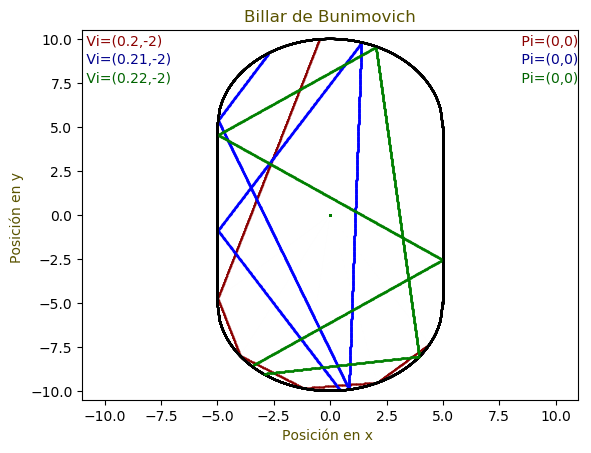

In [267]:
billar(0,0,0.2,-2,5,10)  #rojo: graficamos una particula que sale del origen con velocidad (0.2, -2)
billarblue(0,0,0.21,-2,5,10) #azul: graficamos una particula que sale del origen con velocidad (0.21, -2)
billargreen(0,0,0.22,-2,5,10) #verde: graficamos una particula que sale del origen con velocidades (0.22, -2)
annotate(" Pi=(0,0)",
	xy=[1;0.95],
	xycoords="axes fraction",
	color="darkred",
	ha="right",
	va="bottom")
annotate(" Vi=(0.2,-2)",
	xy=[0;0.95],
	xycoords="axes fraction",
	color="darkred",
	ha="left",
	va="bottom")
annotate(" Pi=(0,0)",
	xy=[1;0.9],
	xycoords="axes fraction",
	color="darkblue",
	ha="right",
	va="bottom")
annotate(" Vi=(0.21,-2)",
	xy=[0;0.9],
	xycoords="axes fraction",
	color="darkblue",
	ha="left",
	va="bottom")
annotate(" Pi=(0,0)",
	xy=[1;0.85],
	xycoords="axes fraction",
	color="darkgreen",
	ha="right",
	va="bottom")
annotate(" Vi=(0.22,-2)",
	xy=[0;0.85],
	xycoords="axes fraction",
	color="darkgreen",
	ha="left",
	va="bottom");

Por último, del 10 al 15:

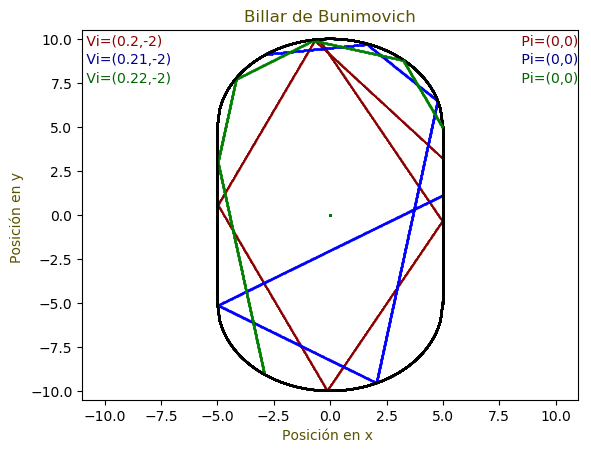

In [269]:
billar(0,0,0.2,-2,10,15)  #rojo: graficamos una particula que sale del origen con velocidad (0.2, -2)
billarblue(0,0,0.21,-2,10,15) #azul: graficamos una particula que sale del origen con velocidad (0.21, -2)
billargreen(0,0,0.22,-2,10,15) #verde: graficamos una particula que sale del origen con velocidades (0.22, -2)
annotate(" Pi=(0,0)",
	xy=[1;0.95],
	xycoords="axes fraction",
	color="darkred",
	ha="right",
	va="bottom")
annotate(" Vi=(0.2,-2)",
	xy=[0;0.95],
	xycoords="axes fraction",
	color="darkred",
	ha="left",
	va="bottom")
annotate(" Pi=(0,0)",
	xy=[1;0.9],
	xycoords="axes fraction",
	color="darkblue",
	ha="right",
	va="bottom")
annotate(" Vi=(0.21,-2)",
	xy=[0;0.9],
	xycoords="axes fraction",
	color="darkblue",
	ha="left",
	va="bottom")
annotate(" Pi=(0,0)",
	xy=[1;0.85],
	xycoords="axes fraction",
	color="darkgreen",
	ha="right",
	va="bottom")
annotate(" Vi=(0.22,-2)",
	xy=[0;0.85],
	xycoords="axes fraction",
	color="darkgreen",
	ha="left",
	va="bottom");

Se bserva que incluso para la misma posición inicial, las trayectorias tienen un comportamiento muy diferente para una diferencia de _"0.01"_ en tan solo una de las componentes de la velocidad, obteniendo un sistema caótico.

# Billar de Sinaí

A continuación, vamos a introducir un obstáculo en el centro del circulo....

In [274]:
function billarobs(x0,y0,vx,vy,prim,it)
 err=0.02                      # definimos el error como !!!poner en latex !!!!
 posBarrx=5                    # Se define la posición de las barreras laterales
 t=linspace(0,100,10000);      # Se define lista de 10000 "tiempos"
    
for j in 1:it 
       posx = zeros(10000);     # Se define una lista de 1000 entradas para guardar la posicion en x & y.
       posy = zeros(10000);
    choquex = zeros(it);     # Lista para guardar donde choca en x & y
    choquey = zeros(it);

    for i in 1:10000    # Primero guardemos la trayectoria de las particula en las siguientes listas:    
        posx[i] = x0+vx*t[i]
        posy[i] = y0+vy*t[i]
    end
                                 # Se revisa la posición de choque como sigue:
            for i in 1:10000     # Se hacen correr todos los puntos (x,y) de la trayectoria y se observa cuando 
                                 # cumplen la ecuación de la circunferencia " y = sqrt(1-x^2) "
            
      # Una vez guardado los datos, se definen una serie de ifs que revisan cuando la posición de la partícula
            # cumple con las ecuaciones del circulo x^2+y^2=r^2. Se hacer 4 ifs para los dos medios circulos
                # y dos más para las barreras laterales.
            

                    # medio circulo superior derecha
                    if abs(posy[i]-5-sqrt.(25.01-(posx[i])*(posx[i])))<err  && 0<posx[i]<5.1                      
                          x0 = posx[i]; # guardamos la posicion del choque en la posicion donde se cunple el if
                          y0 = posy[i];
                           m = x0/sqrt(abs(25.1-x0^2)); # encontramos la pendiente del plano tangente definido 
                                                          # por su derivada
                            if x0 > 0                     # definimos esta if para que no haya problemas
                                m=-abs(m);
                                end 
                        phi = atand(m);                   # El ángulo del plano con la horizontaL
                         cx = cosd(phi);                  # Se calculan la componentes de la normal
                         cy = sind(phi);                  # cy es la normal en x y cy la normal en y
                          n = SVector(abs(cy), abs(cx));  # definimos la normal con lso vectores normales
                          V = SVector(vx, vy);            # Se define el vector director con las vel. iniciales
                         k2 = dot(2V,n)                   # a continuación se encuentra el vector resultante
                         k3 = k2*n;                       # esto pudo haber sido una sola linea pero
                          r = V-k3;                       # había problemas y por eso no salía
                         vx = r[1];                       # Se renombran "vx" y "vy" como la primera                 
                         vy = r[2];                       # y segunda entrada del vector resultante
                         x0 = posx[i-1];                  # por ultimo, guardamos un paso antes para 
                         y0 = posy[i-1];                  # que no haya problemas en la siguiente iteración.
                              break
                
              #medio circulo superior de la izquierda!!!    
                elseif abs(posy[i]-5-sqrt.(25.01-(posx[i])*(posx[i])))<err  && 0>posx[i]>-5.1                    
                         x0 = posx[i];
                          y0 = posy[i];
                         m = x0/sqrt(abs(25.1-x0^2));
                            if x0 > 0
                                m=-abs(m);
                                end 
                        phi = atand(m); 
                         cx = cosd(phi);  
                         cy = sind(phi);9
                          n = SVector(abs(cy), -abs(cx));
                          V = SVector(vx, vy);
                         k2 = dot(2V,n)
                         k3 = k2*n;
                          r = V-k3;
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break
                
                        #medio círculo inferior de la izquierda
                        elseif abs(posy[i]+5+sqrt.(25.01-(posx[i])*(posx[i])))<err  &&   0>posx[i]>-5.1                 
                          x0 = posx[i];
                          y0 = posy[i];
                         m = x0/sqrt(abs(25.1-x0^2));
                            if x0 > 0
                                m=abs(m);
                                end 
                        phi = atand(m);
                         cx = cosd(phi);
                         cy = sind(phi);
                          n = SVector(-abs(cy), -abs(cx));
                          V = SVector(vx, vy);
                         k2 = dot(2V,n);
                         k3 = k2*n;
                          r = V-k3;
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break
                
                  #medio círculo inferior de la derecha:
                        elseif abs(posy[i]+5+sqrt.(25.01-(posx[i])*(posx[i])))<err  && 0<posx[i]<5.1              
                        x0 = posx[i];
                          y0 = posy[i];
                         m = x0/sqrt(abs(25.1-x0^2));
                            if x0 > 0
                                m=abs(m);
                                end 
                        phi = atand(m); 
                         cx = cosd(phi);
                         cy = sind(phi);
                          n = SVector(-abs(cy), abs(cx));
                          V = SVector(vx, vy); 
                         k2 = dot(2V,n);
                         k3 = k2*n;
                          r = V-k3;
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break
                
                

                 # por ultimo la condicion del OBSTACULO interior
                
                 # interior superior derecha
                elseif abs(posy[i]-sqrt.(abs.(1-(posx[i])*(posx[i]))))<err   && -0.1<posx[i]<1.2
                          x0 = posx[i]; # guardamos la posicion del choque en la posicion donde se cunple el if
                          y0 = posy[i];
                           m = x0/sqrt(abs(1.1-x0^2));  
                                                          # por su derivada
                            if x0 > 0                     # definimos esta if para que no haya problemas
                                m=-abs(m);
                                end 
                    
                        phi = atand(m);         # El ángulo del plano con la horizontaL
                         cx = cosd(phi);        # Se calculan la componentes de la normal
                         cy = sind(phi);        # cy es la normal en x y cy la normal en y
                          n = SVector(abs(cy), abs(cx));   # definimos la normal con lso vectores normales
                          V = SVector(vx, vy);  # Se define el vector director con las velocidades iniciales
                         k2 = dot(2V,n)         # a continuación se encuentra el vector resultante
                         k3 = k2*n;             # esto pudo haber sido una sola linea pero
                          r = V-k3;                     #había problemas y por eso no salía
                         vx = r[1];             # Se renombran "vx" y "vy" como la primera y segunda entrada del                   
                         vy = r[2];             # vector resultante
                         x0 = posx[i-1];        # por ultimo, guardamos un paso antes para que no haya problemas
                         y0 = posy[i-1];        # en la siguiente iteración.
                              break
                
                  # interior superior izq
                elseif abs(posy[i]-sqrt.(abs.(1-(posx[i])*(posx[i]))))<err  &&  -0.1>posx[i]>-1.1  
                          x0 = posx[i];
                          y0 = posy[i];
                           m = x0/sqrt(abs(1.1-x0^2));
                
                            if x0 > 0
                             m=-abs(m);
                                end 
                    
                        phi = atand(m); 
                         cx = cosd(phi);  
                         cy = sind(phi);
                          n = SVector(abs(cy), -abs(cx));
                          V = SVector(vx, vy);
                         k2 = dot(2V,n)
                         k3 = k2*n;
                          r = V-k3;
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break
            
                        # interior inferior izq
                        elseif abs(posy[i]+sqrt.(abs.(1-(posx[i])*(posx[i]))))<err  &&   0>posx[i]>-1.1  
                          x0 = posx[i];
                          y0 = posy[i];
                         m = x0/sqrt(abs(1.1-x0^2));
                
                            if x0 > 0
                                m=abs(m);
                                end 
                
                        phi = atand(m);
                         cx = cosd(phi);
                         cy = sind(phi);
                          n = SVector(-abs(cy), -abs(cx));
                          V = SVector(vx, vy);
                         k2 = dot(2V,n);
                         k3 = k2*n;
                          r = V-k3;
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break
                
                  # interior inferior derecha
                        elseif abs(posy[i]+sqrt.(abs.(1-(posx[i])*(posx[i]))))<err  && 0 < posx[i] < 1.1 
                        x0 = posx[i];
                          y0 = posy[i];
                         m = x0/sqrt(abs(1.1-x0^2));
                
                            if x0 > 0
                                m=abs(m);
                                end 
                
                        phi = atand(m); 
                         cx = cosd(phi);
                         cy = sind(phi);
                          n = SVector(-abs(cy), abs(cx));
                          V = SVector(vx, vy); 
                         k2 = dot(2V,n);
                         k3 = k2*n;
                          r = V-k3;
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break
                
                       #Ahora para las paredes verticales:
                          #pared izquierda
                            elseif abs(posx[i]+posBarrx)<err  && posx[i]<0 &&abs(posy[i])<6
                
                                    x0 = posx[i-1]     #para no tener problemas en la siguiente iteración
                                    y0 = posy[i];
                                    vx = -vx;          #Ya que es lo única componente que cambia 
                                     break
                         
                            #pared derecha
                            elseif abs(posx[i]-posBarrx)<err && posx[i]>0 && abs(posy[i])<6
                
                                    x0 = posx[i-1];
                                    y0 = posy[i];
                                    vx = -vx;
                                     break    
                    
            end
       
         if j>prim
             push!(choquex,posx[i]) # Para cada "i" guardamos "posx[i]" y "posy[i]" en las listas
             push!(choquey,posy[i]) # "choquex" y "choquey"
            end
             end
 
   x1 = linspace(-5.0, 5, 100)           # Se define un linspace para poder graficar los medios círculos
  yar = 5+sqrt.(abs.(25-x1.*x1))         # Se definen las ecuaciones de los medios circulos para poder graficar
  yab = -5-sqrt.(abs.(25-x1.*x1))
  x12 = linspace(-1, 1, 100)             # Se define un linspace para poder graficar el círculo central en un futuro
 yar2 = sqrt.(abs.(1-x12.*x12))          # Se definen las ecuaciones del círculo central para graficar 
 yab2 = -sqrt.(abs.(1-x12.*x12))     
        
 plot(x1, yab,color="black")             #estas son las graficas de los circulos
 plot(x1, yar,color="black")
 plot(x12, yab2,color="orange")
 plot(x12, yar2,color="orange")
           
 plot([-5,-5],[-5,5],linestyle="-",linewidth=1.5,color="black")         # aquí graficamos las lineas horizontales
 plot([5,5],[-5,5],linestyle="-",linewidth=1.5,color="black")
              
 xlim(-11, 11)
 ylim(-10.5, 10.5)
        
         #Punto central (sólo por estética)
        
plot(-0.45,0,marker="o",markersize=17.5,color="orange")
plot(0.45,0,marker="o",markersize=17.5,color="orange")
plot(0,0,marker="o",markersize=25,color="orange")
     
plot(choquex,choquey, ".",alpha=1, linewidth=0.002, color="darkred", markersize=1,antialiased= "true" )   
        # esta es la grafica de las trayectorias
title("Billar de Sinaí",color="#5A5300")
xlabel("Posición en x ",color="#5A5300")
ylabel("Posición en y ",color="#5A5300")
legend()  
    end
end

billarobs (generic function with 1 method)

Aqui la posición inicial debe de estar fuera del circulo interior

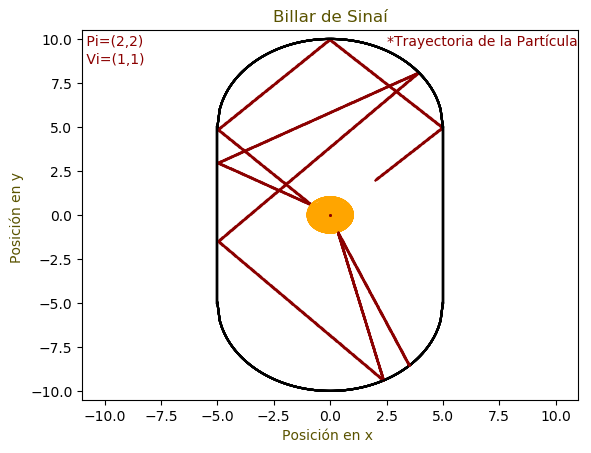

In [277]:
billarobs(2,2, 1, 1, 0,10)
annotate(" Pi=(2,2)",
	xy=[0;0.95],
	xycoords="axes fraction",
	color="darkred",
	ha="left",
	va="bottom")
annotate(" Vi=(1,1)",
	xy=[0;0.9],
	xycoords="axes fraction",
	color="darkred",
	ha="left",
	va="bottom")
annotate("*Trayectoria de la Partícula",
	xy=[1;0.95],
	xycoords="axes fraction",
	color="darkred",
	ha="right",
	va="bottom");

Igualmente definimos varias funciones para ver su comportamiento caótico:

In [326]:
function billarobsblue(x0,y0,vx,vy,prim, it)
 err=0.02                      # definimos el error como !!!poner en latex !!!!
 posBarrx=5                    # Se define la posición de las barreras laterales
 t=linspace(0,100,10000);      # Se define lista de 10000 "tiempos"
    
for j in 1:it 
       posx = zeros(10000);     # Se define una lista de 1000 entradas para guardar la posicion en x & y.
       posy = zeros(10000);
    choquex = zeros(it);     # Lista para guardar donde choca en x & y
    choquey = zeros(it);

    for i in 1:10000    # Primero guardemos la trayectoria de las particula en las siguientes listas:    
        posx[i] = x0+vx*t[i]
        posy[i] = y0+vy*t[i]
    end
                                 # Se revisa la posición de choque como sigue:
            for i in 1:10000     # Se hacen correr todos los puntos (x,y) de la trayectoria y se observa cuando 
                                 # cumplen la ecuación de la circunferencia " y = sqrt(1-x^2) "
            
      # Una vez guardado los datos, se definen una serie de ifs que revisan cuando la posición de la partícula
            # cumple con las ecuaciones del circulo x^2+y^2=r^2. Se hacer 4 ifs para los dos medios circulos
                # y dos más para las barreras laterales.
            

                    # medio circulo superior derecha
                    if abs(posy[i]-5-sqrt.(25.01-(posx[i])*(posx[i])))<err  && 0<posx[i]<5.1                      
                          x0 = posx[i]; # guardamos la posicion del choque en la posicion donde se cunple el if
                          y0 = posy[i];
                           m = x0/sqrt(abs(25.1-x0^2)); # encontramos la pendiente del plano tangente definido 
                                                          # por su derivada
                            if x0 > 0                     # definimos esta if para que no haya problemas
                                m=-abs(m);
                                end 
                        phi = atand(m);                   # El ángulo del plano con la horizontaL
                         cx = cosd(phi);                  # Se calculan la componentes de la normal
                         cy = sind(phi);                  # cy es la normal en x y cy la normal en y
                          n = SVector(abs(cy), abs(cx));  # definimos la normal con lso vectores normales
                          V = SVector(vx, vy);            # Se define el vector director con las vel. iniciales
                         k2 = dot(2V,n)                   # a continuación se encuentra el vector resultante
                         k3 = k2*n;                       # esto pudo haber sido una sola linea pero
                          r = V-k3;                       # había problemas y por eso no salía
                         vx = r[1];                       # Se renombran "vx" y "vy" como la primera                 
                         vy = r[2];                       # y segunda entrada del vector resultante
                         x0 = posx[i-1];                  # por ultimo, guardamos un paso antes para 
                         y0 = posy[i-1];                  # que no haya problemas en la siguiente iteración.
                              break
                
              #medio circulo superior de la izquierda!!!    
                elseif abs(posy[i]-5-sqrt.(25.01-(posx[i])*(posx[i])))<err  && 0>posx[i]>-5.1                    
                         x0 = posx[i];
                          y0 = posy[i];
                         m = x0/sqrt(abs(25.1-x0^2));
                            if x0 > 0
                                m=-abs(m);
                                end 
                        phi = atand(m); 
                         cx = cosd(phi);  
                         cy = sind(phi);9
                          n = SVector(abs(cy), -abs(cx));
                          V = SVector(vx, vy);
                         k2 = dot(2V,n)
                         k3 = k2*n;
                          r = V-k3;
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break
                
                        #medio círculo inferior de la izquierda
                        elseif abs(posy[i]+5+sqrt.(25.01-(posx[i])*(posx[i])))<err  &&   0>posx[i]>-5.1                 
                          x0 = posx[i];
                          y0 = posy[i];
                         m = x0/sqrt(abs(25.1-x0^2));
                            if x0 > 0
                                m=abs(m);
                                end 
                        phi = atand(m);
                         cx = cosd(phi);
                         cy = sind(phi);
                          n = SVector(-abs(cy), -abs(cx));
                          V = SVector(vx, vy);
                         k2 = dot(2V,n);
                         k3 = k2*n;
                          r = V-k3;
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break
                
                  #medio círculo inferior de la derecha:
                        elseif abs(posy[i]+5+sqrt.(25.01-(posx[i])*(posx[i])))<err  && 0<posx[i]<5.1              
                        x0 = posx[i];
                          y0 = posy[i];
                         m = x0/sqrt(abs(25.1-x0^2));
                            if x0 > 0
                                m=abs(m);
                                end 
                        phi = atand(m); 
                         cx = cosd(phi);
                         cy = sind(phi);
                          n = SVector(-abs(cy), abs(cx));
                          V = SVector(vx, vy); 
                         k2 = dot(2V,n);
                         k3 = k2*n;
                          r = V-k3;
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break
                
                

                 # por ultimo la condicion del OBSTACULO interior
                
                 # interior superior derecha
                elseif abs(posy[i]-sqrt.(abs.(1-(posx[i])*(posx[i]))))<err   && -0.1<posx[i]<1.2
                          x0 = posx[i]; # guardamos la posicion del choque en la posicion donde se cunple el if
                          y0 = posy[i];
                           m = x0/sqrt(abs(1.1-x0^2));  
                                                          # por su derivada
                            if x0 > 0                     # definimos esta if para que no haya problemas
                                m=-abs(m);
                                end 
                    
                        phi = atand(m);         # El ángulo del plano con la horizontaL
                         cx = cosd(phi);        # Se calculan la componentes de la normal
                         cy = sind(phi);        # cy es la normal en x y cy la normal en y
                          n = SVector(abs(cy), abs(cx));   # definimos la normal con lso vectores normales
                          V = SVector(vx, vy);  # Se define el vector director con las velocidades iniciales
                         k2 = dot(2V,n)         # a continuación se encuentra el vector resultante
                         k3 = k2*n;             # esto pudo haber sido una sola linea pero
                          r = V-k3;                     #había problemas y por eso no salía
                         vx = r[1];             # Se renombran "vx" y "vy" como la primera y segunda entrada del                   
                         vy = r[2];             # vector resultante
                         x0 = posx[i-1];        # por ultimo, guardamos un paso antes para que no haya problemas
                         y0 = posy[i-1];        # en la siguiente iteración.
                              break
                
                  # interior superior izq
                elseif abs(posy[i]-sqrt.(abs.(1-(posx[i])*(posx[i]))))<err  &&  -0.1>posx[i]>-1.1  
                          x0 = posx[i];
                          y0 = posy[i];
                           m = x0/sqrt(abs(1.1-x0^2));
                
                            if x0 > 0
                             m=-abs(m);
                                end 
                    
                        phi = atand(m); 
                         cx = cosd(phi);  
                         cy = sind(phi);
                          n = SVector(abs(cy), -abs(cx));
                          V = SVector(vx, vy);
                         k2 = dot(2V,n)
                         k3 = k2*n;
                          r = V-k3;
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break
            
                        # interior inferior izq
                        elseif abs(posy[i]+sqrt.(abs.(1-(posx[i])*(posx[i]))))<err  &&   0>posx[i]>-1.1  
                          x0 = posx[i];
                          y0 = posy[i];
                         m = x0/sqrt(abs(1.1-x0^2));
                
                            if x0 > 0
                                m=abs(m);
                                end 
                
                        phi = atand(m);
                         cx = cosd(phi);
                         cy = sind(phi);
                          n = SVector(-abs(cy), -abs(cx));
                          V = SVector(vx, vy);
                         k2 = dot(2V,n);
                         k3 = k2*n;
                          r = V-k3;
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break
                
                  # interior inferior derecha
                        elseif abs(posy[i]+sqrt.(abs.(1-(posx[i])*(posx[i]))))<err  && 0 < posx[i] < 1.1 
                        x0 = posx[i];
                          y0 = posy[i];
                         m = x0/sqrt(abs(1.1-x0^2));
                
                            if x0 > 0
                                m=abs(m);
                                end 
                
                        phi = atand(m); 
                         cx = cosd(phi);
                         cy = sind(phi);
                          n = SVector(-abs(cy), abs(cx));
                          V = SVector(vx, vy); 
                         k2 = dot(2V,n);
                         k3 = k2*n;
                          r = V-k3;
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break
                
                       #Ahora para las paredes verticales:
                          #pared izquierda
                            elseif abs(posx[i]+posBarrx)<err  && posx[i]<0 &&abs(posy[i])<6
                
                                    x0 = posx[i-1]     #para no tener problemas en la siguiente iteración
                                    y0 = posy[i];
                                    vx = -vx;          #Ya que es lo única componente que cambia 
                                     break
                         
                            #pared derecha
                            elseif abs(posx[i]-posBarrx)<err && posx[i]>0 && abs(posy[i])<6
                
                                    x0 = posx[i-1];
                                    y0 = posy[i];
                                    vx = -vx;
                                     break    
                    
            end
       
              if j>prim
             push!(choquex,posx[i]) # Para cada "i" guardamos "posx[i]" y "posy[i]" en las listas
             push!(choquey,posy[i]) # "choquex" y "choquey"
            end
             end
 
   x1 = linspace(-5.0, 5, 100)           # Se define un linspace para poder graficar los medios círculos
  yar = 5+sqrt.(abs.(25-x1.*x1))         # Se definen las ecuaciones de los medios circulos para poder graficar
  yab = -5-sqrt.(abs.(25-x1.*x1))
  x12 = linspace(-1, 1, 100)             # Se define un linspace para poder graficar el círculo central en un futuro
 yar2 = sqrt.(abs.(1-x12.*x12))          # Se definen las ecuaciones del círculo central para graficar 
 yab2 = -sqrt.(abs.(1-x12.*x12))     
        
 plot(x1, yab,color="black")             #estas son las graficas de los circulos
 plot(x1, yar,color="black")
 plot(x12, yab2,color="orange")
 plot(x12, yar2,color="orange")
           
 plot([-5,-5],[-5,5],linestyle="-",linewidth=1.5,color="black")         # aquí graficamos las lineas horizontales
 plot([5,5],[-5,5],linestyle="-",linewidth=1.5,color="black")
              
 xlim(-11, 11)
 ylim(-10.5, 10.5)

plot(choquex,choquey, ".",alpha=1, linewidth=0.002, color="blue", markersize=1,antialiased=true)    # esta es la grafica de las trayectorias
                                                                      #(lo que no sale bien)
    end
end


function billarobsgreen(x0,y0,vx,vy,prim,it)
 err=0.02                      # definimos el error como !!!poner en latex !!!!
 posBarrx=5                    # Se define la posición de las barreras laterales
 t=linspace(0,100,10000);      # Se define lista de 10000 "tiempos"
    
for j in 1:it 
       posx = zeros(10000);     # Se define una lista de 1000 entradas para guardar la posicion en x & y.
       posy = zeros(10000);
    choquex = zeros(it);     # Lista para guardar donde choca en x & y
    choquey = zeros(it);

    for i in 1:10000    # Primero guardemos la trayectoria de las particula en las siguientes listas:    
        posx[i] = x0+vx*t[i]
        posy[i] = y0+vy*t[i]
    end
                                 # Se revisa la posición de choque como sigue:
            for i in 1:10000     # Se hacen correr todos los puntos (x,y) de la trayectoria y se observa cuando 
                                 # cumplen la ecuación de la circunferencia " y = sqrt(1-x^2) "
            
      # Una vez guardado los datos, se definen una serie de ifs que revisan cuando la posición de la partícula
            # cumple con las ecuaciones del circulo x^2+y^2=r^2. Se hacer 4 ifs para los dos medios circulos
                # y dos más para las barreras laterales.
            

                    # medio circulo superior derecha
                    if abs(posy[i]-5-sqrt.(25.01-(posx[i])*(posx[i])))<err  && 0<posx[i]<5.1                      
                          x0 = posx[i]; # guardamos la posicion del choque en la posicion donde se cunple el if
                          y0 = posy[i];
                           m = x0/sqrt(abs(25.1-x0^2)); # encontramos la pendiente del plano tangente definido 
                                                          # por su derivada
                            if x0 > 0                     # definimos esta if para que no haya problemas
                                m=-abs(m);
                                end 
                        phi = atand(m);                   # El ángulo del plano con la horizontaL
                         cx = cosd(phi);                  # Se calculan la componentes de la normal
                         cy = sind(phi);                  # cy es la normal en x y cy la normal en y
                          n = SVector(abs(cy), abs(cx));  # definimos la normal con lso vectores normales
                          V = SVector(vx, vy);            # Se define el vector director con las vel. iniciales
                         k2 = dot(2V,n)                   # a continuación se encuentra el vector resultante
                         k3 = k2*n;                       # esto pudo haber sido una sola linea pero
                          r = V-k3;                       # había problemas y por eso no salía
                         vx = r[1];                       # Se renombran "vx" y "vy" como la primera                 
                         vy = r[2];                       # y segunda entrada del vector resultante
                         x0 = posx[i-1];                  # por ultimo, guardamos un paso antes para 
                         y0 = posy[i-1];                  # que no haya problemas en la siguiente iteración.
                              break
                
              #medio circulo superior de la izquierda!!!    
                elseif abs(posy[i]-5-sqrt.(25.01-(posx[i])*(posx[i])))<err  && 0>posx[i]>-5.1                    
                         x0 = posx[i];
                          y0 = posy[i];
                         m = x0/sqrt(abs(25.1-x0^2));
                            if x0 > 0
                                m=-abs(m);
                                end 
                        phi = atand(m); 
                         cx = cosd(phi);  
                         cy = sind(phi);9
                          n = SVector(abs(cy), -abs(cx));
                          V = SVector(vx, vy);
                         k2 = dot(2V,n)
                         k3 = k2*n;
                          r = V-k3;
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break
                
                        #medio círculo inferior de la izquierda
                        elseif abs(posy[i]+5+sqrt.(25.01-(posx[i])*(posx[i])))<err  &&   0>posx[i]>-5.1                 
                          x0 = posx[i];
                          y0 = posy[i];
                         m = x0/sqrt(abs(25.1-x0^2));
                            if x0 > 0
                                m=abs(m);
                                end 
                        phi = atand(m);
                         cx = cosd(phi);
                         cy = sind(phi);
                          n = SVector(-abs(cy), -abs(cx));
                          V = SVector(vx, vy);
                         k2 = dot(2V,n);
                         k3 = k2*n;
                          r = V-k3;
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break
                
                  #medio círculo inferior de la derecha:
                        elseif abs(posy[i]+5+sqrt.(25.01-(posx[i])*(posx[i])))<err  && 0<posx[i]<5.1              
                        x0 = posx[i];
                          y0 = posy[i];
                         m = x0/sqrt(abs(25.1-x0^2));
                            if x0 > 0
                                m=abs(m);
                                end 
                        phi = atand(m); 
                         cx = cosd(phi);
                         cy = sind(phi);
                          n = SVector(-abs(cy), abs(cx));
                          V = SVector(vx, vy); 
                         k2 = dot(2V,n);
                         k3 = k2*n;
                          r = V-k3;
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break
                
                

                 # por ultimo la condicion del OBSTACULO interior
                
                 # interior superior derecha
                elseif abs(posy[i]-sqrt.(abs.(1-(posx[i])*(posx[i]))))<err   && -0.1<posx[i]<1.2
                          x0 = posx[i]; # guardamos la posicion del choque en la posicion donde se cunple el if
                          y0 = posy[i];
                           m = x0/sqrt(abs(1.1-x0^2));  
                                                          # por su derivada
                            if x0 > 0                     # definimos esta if para que no haya problemas
                                m=-abs(m);
                                end 
                    
                        phi = atand(m);         # El ángulo del plano con la horizontaL
                         cx = cosd(phi);        # Se calculan la componentes de la normal
                         cy = sind(phi);        # cy es la normal en x y cy la normal en y
                          n = SVector(abs(cy), abs(cx));   # definimos la normal con lso vectores normales
                          V = SVector(vx, vy);  # Se define el vector director con las velocidades iniciales
                         k2 = dot(2V,n)         # a continuación se encuentra el vector resultante
                         k3 = k2*n;             # esto pudo haber sido una sola linea pero
                          r = V-k3;                     #había problemas y por eso no salía
                         vx = r[1];             # Se renombran "vx" y "vy" como la primera y segunda entrada del                   
                         vy = r[2];             # vector resultante
                         x0 = posx[i-1];        # por ultimo, guardamos un paso antes para que no haya problemas
                         y0 = posy[i-1];        # en la siguiente iteración.
                              break
                
                  # interior superior izq
                elseif abs(posy[i]-sqrt.(abs.(1-(posx[i])*(posx[i]))))<err  &&  -0.1>posx[i]>-1.1  
                          x0 = posx[i];
                          y0 = posy[i];
                           m = x0/sqrt(abs(1.1-x0^2));
                
                            if x0 > 0
                             m=-abs(m);
                                end 
                    
                        phi = atand(m); 
                         cx = cosd(phi);  
                         cy = sind(phi);
                          n = SVector(abs(cy), -abs(cx));
                          V = SVector(vx, vy);
                         k2 = dot(2V,n)
                         k3 = k2*n;
                          r = V-k3;
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break
            
                        # interior inferior izq
                        elseif abs(posy[i]+sqrt.(abs.(1-(posx[i])*(posx[i]))))<err  &&   0>posx[i]>-1.1  
                          x0 = posx[i];
                          y0 = posy[i];
                         m = x0/sqrt(abs(1.1-x0^2));
                
                            if x0 > 0
                                m=abs(m);
                                end 
                
                        phi = atand(m);
                         cx = cosd(phi);
                         cy = sind(phi);
                          n = SVector(-abs(cy), -abs(cx));
                          V = SVector(vx, vy);
                         k2 = dot(2V,n);
                         k3 = k2*n;
                          r = V-k3;
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break
                
                  # interior inferior derecha
                        elseif abs(posy[i]+sqrt.(abs.(1-(posx[i])*(posx[i]))))<err  && 0 < posx[i] < 1.1 
                        x0 = posx[i];
                          y0 = posy[i];
                         m = x0/sqrt(abs(1.1-x0^2));
                
                            if x0 > 0
                                m=abs(m);
                                end 
                
                        phi = atand(m); 
                         cx = cosd(phi);
                         cy = sind(phi);
                          n = SVector(-abs(cy), abs(cx));
                          V = SVector(vx, vy); 
                         k2 = dot(2V,n);
                         k3 = k2*n;
                          r = V-k3;
                         vx = r[1];
                         vy = r[2];
                         x0 = posx[i-1];
                         y0 = posy[i-1];
                              break
                
                       #Ahora para las paredes verticales:
                          #pared izquierda
                            elseif abs(posx[i]+posBarrx)<err  && posx[i]<0 &&abs(posy[i])<6
                
                                    x0 = posx[i-1]     #para no tener problemas en la siguiente iteración
                                    y0 = posy[i];
                                    vx = -vx;          #Ya que es lo única componente que cambia 
                                     break
                         
                            #pared derecha
                            elseif abs(posx[i]-posBarrx)<err && posx[i]>0 && abs(posy[i])<6
                
                                    x0 = posx[i-1];
                                    y0 = posy[i];
                                    vx = -vx;
                                     break    
                    
            end
        if j>prim
             push!(choquex,posx[i]) # Para cada "i" guardamos "posx[i]" y "posy[i]" en las listas
             push!(choquey,posy[i]) # "choquex" y "choquey"
            end
             end
 
   x1 = linspace(-5.0, 5, 100)           # Se define un linspace para poder graficar los medios círculos
  yar = 5+sqrt.(abs.(25-x1.*x1))         # Se definen las ecuaciones de los medios circulos para poder graficar
  yab = -5-sqrt.(abs.(25-x1.*x1))
  x12 = linspace(-1, 1, 100)             # Se define un linspace para poder graficar el círculo central en un futuro
 yar2 = sqrt.(abs.(1-x12.*x12))          # Se definen las ecuaciones del círculo central para graficar 
 yab2 = -sqrt.(abs.(1-x12.*x12))     
        
 plot(x1, yab,color="black")             #estas son las graficas de los circulos
 plot(x1, yar,color="black")
 plot(x12, yab2,color="orange")
 plot(x12, yar2,color="orange")
           
 plot([-5,-5],[-5,5],linestyle="-",linewidth=1.5,color="black")         # aquí graficamos las lineas horizontales
 plot([5,5],[-5,5],linestyle="-",linewidth=1.5,color="black")
              
 xlim(-11, 11)
 ylim(-10.5, 10.5)
     
plot(choquex,choquey, ".",alpha=1, linewidth=0.002, color="green", markersize=1,antialiased=true)   # esta es la grafica de las trayectorias
    end
end

billarobsgreen (generic function with 1 method)

Veamos las primeras 3 colisiones:

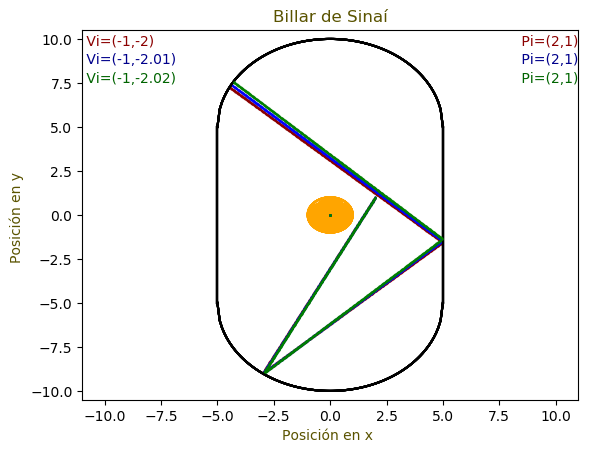

In [327]:
billarobs(2,1,-1,-2,0,3)
billarobsblue(2,1,-1,-2.01,0,3)
billarobsgreen(2,1,-1,-2.02,0,3)

annotate(" Pi=(2,1)",
	xy=[1;0.95],
	xycoords="axes fraction",
	color="darkred",
	ha="right",
	va="bottom")
annotate(" Vi=(-1,-2)",
	xy=[0;0.95],
	xycoords="axes fraction",
	color="darkred",
	ha="left",
	va="bottom")
annotate(" Pi=(2,1)",
	xy=[1;0.9],
	xycoords="axes fraction",
	color="darkblue",
	ha="right",
	va="bottom")
annotate(" Vi=(-1,-2.01)",
	xy=[0;0.9],
	xycoords="axes fraction",
	color="darkblue",
	ha="left",
	va="bottom")
annotate(" Pi=(2,1)",
	xy=[1;0.85],
	xycoords="axes fraction",
	color="darkgreen",
	ha="right",
	va="bottom")
annotate(" Vi=(-1,-2.02)",
	xy=[0;0.85],
	xycoords="axes fraction",
	color="darkgreen",
	ha="left",
	va="bottom");

Veamos de la 3 a la 7:

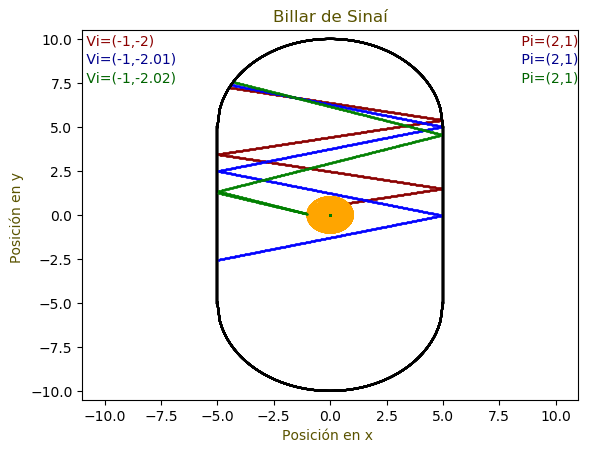

In [332]:
billarobs(2,1,-1,-2,3,7)
billarobsblue(2,1,-1,-2.01,3,7)
billarobsgreen(2,1,-1,-2.02,3,7)

annotate(" Pi=(2,1)",
	xy=[1;0.95],
	xycoords="axes fraction",
	color="darkred",
	ha="right",
	va="bottom")
annotate(" Vi=(-1,-2)",
	xy=[0;0.95],
	xycoords="axes fraction",
	color="darkred",
	ha="left",
	va="bottom")
annotate(" Pi=(2,1)",
	xy=[1;0.9],
	xycoords="axes fraction",
	color="darkblue",
	ha="right",
	va="bottom")
annotate(" Vi=(-1,-2.01)",
	xy=[0;0.9],
	xycoords="axes fraction",
	color="darkblue",
	ha="left",
	va="bottom")
annotate(" Pi=(2,1)",
	xy=[1;0.85],
	xycoords="axes fraction",
	color="darkgreen",
	ha="right",
	va="bottom")
annotate(" Vi=(-1,-2.02)",
	xy=[0;0.85],
	xycoords="axes fraction",
	color="darkgreen",
	ha="left",
	va="bottom");

Aquí ya se observa caos. Veamos de la 7 a la 10:

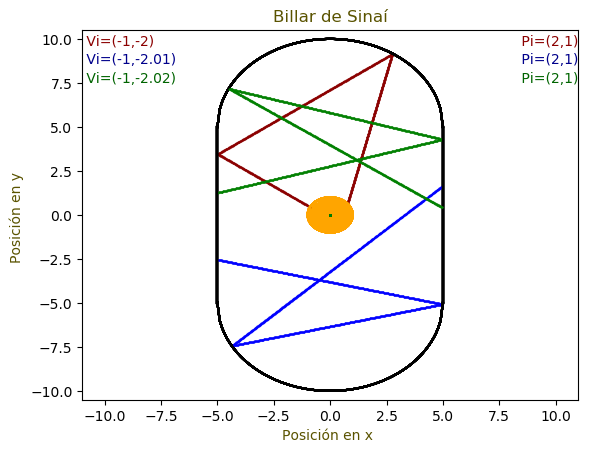

In [330]:
billarobs(2,1,-1,-2,7,10)
billarobsblue(2,1,-1,-2.01,7,10)
billarobsgreen(2,1,-1,-2.02,7,10)

annotate(" Pi=(2,1)",
	xy=[1;0.95],
	xycoords="axes fraction",
	color="darkred",
	ha="right",
	va="bottom")
annotate(" Vi=(-1,-2)",
	xy=[0;0.95],
	xycoords="axes fraction",
	color="darkred",
	ha="left",
	va="bottom")
annotate(" Pi=(2,1)",
	xy=[1;0.9],
	xycoords="axes fraction",
	color="darkblue",
	ha="right",
	va="bottom")
annotate(" Vi=(-1,-2.01)",
	xy=[0;0.9],
	xycoords="axes fraction",
	color="darkblue",
	ha="left",
	va="bottom")
annotate(" Pi=(2,1)",
	xy=[1;0.85],
	xycoords="axes fraction",
	color="darkgreen",
	ha="right",
	va="bottom")
annotate(" Vi=(-1,-2.02)",
	xy=[0;0.85],
	xycoords="axes fraction",
	color="darkgreen",
	ha="left",
	va="bottom");

A continuación las primeras 15 colisiones:

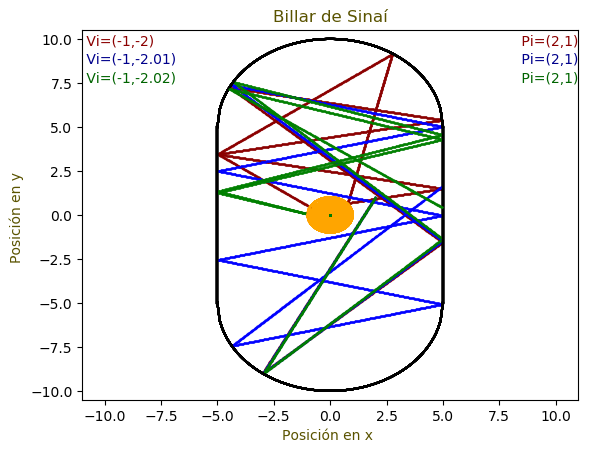

In [337]:
billarobs(2,1,-1,-2,0,10)
billarobsblue(2,1,-1,-2.01,0,10)
billarobsgreen(2,1,-1,-2.02,0,10)

annotate(" Pi=(2,1)",
	xy=[1;0.95],
	xycoords="axes fraction",
	color="darkred",
	ha="right",
	va="bottom")
annotate(" Vi=(-1,-2)",
	xy=[0;0.95],
	xycoords="axes fraction",
	color="darkred",
	ha="left",
	va="bottom")
annotate(" Pi=(2,1)",
	xy=[1;0.9],
	xycoords="axes fraction",
	color="darkblue",
	ha="right",
	va="bottom")
annotate(" Vi=(-1,-2.01)",
	xy=[0;0.9],
	xycoords="axes fraction",
	color="darkblue",
	ha="left",
	va="bottom")
annotate(" Pi=(2,1)",
	xy=[1;0.85],
	xycoords="axes fraction",
	color="darkgreen",
	ha="right",
	va="bottom")
annotate(" Vi=(-1,-2.02)",
	xy=[0;0.85],
	xycoords="axes fraction",
	color="darkgreen",
	ha="left",
	va="bottom");

Se observa un sistema que entra en caos para menores repeticiones que el Billar de Bunimovich.

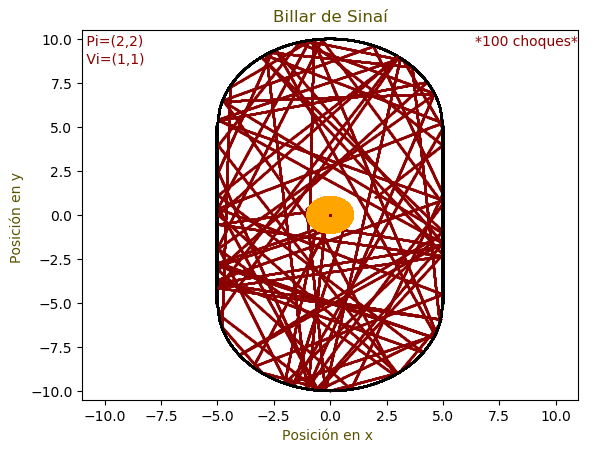

In [341]:
billarobs(2,1,1,1,0,100)
annotate(" Pi=(2,2)",
	xy=[0;0.95],
	xycoords="axes fraction",
	color="darkred",
	ha="left",
	va="bottom")
annotate(" Vi=(1,1)",
	xy=[0;0.9],
	xycoords="axes fraction",
	color="darkred",
	ha="left",
	va="bottom")
annotate("*100 choques*",
	xy=[1;0.95],
	xycoords="axes fraction",
	color="darkred",
	ha="right",
	va="bottom");

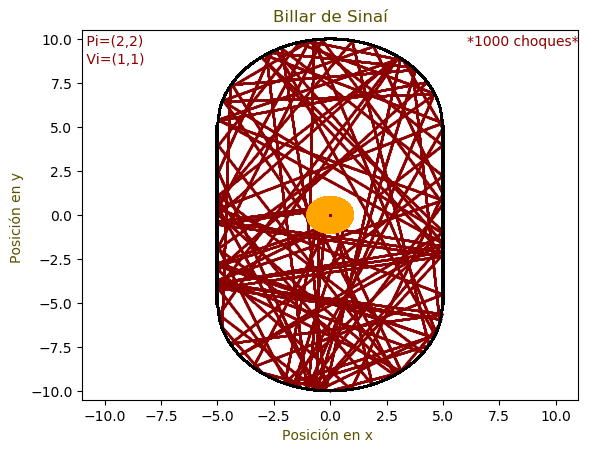

In [342]:
#NO LO CORRAN, TARDA BASTANTE
#billarobs(2,1,1,1,0,1000)
annotate(" Pi=(2,2)",
	xy=[0;0.95],
	xycoords="axes fraction",
	color="darkred",
	ha="left",
	va="bottom")
annotate(" Vi=(1,1)",
	xy=[0;0.9],
	xycoords="axes fraction",
	color="darkred",
	ha="left",
	va="bottom")
annotate("*1000 choques*",
	xy=[1;0.95],
	xycoords="axes fraction",
	color="darkred",
	ha="right",
	va="bottom");